In [1]:
import torch
import numpy as np
import pandas as pd
from torch import optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from preprocess import CMAPSSSlidingWin
from train import TrainUtil

In [2]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [3]:
class LSTMHCAtn(nn.Module):
    def __init__(self):
        super(LSTMHCAtn, self).__init__()
        self.lstm = nn.LSTM(batch_first=True, input_size=17, hidden_size=50, num_layers=1)
        self.attenion = Attention3dBlock()
        self.linear = nn.Sequential(
            nn.Linear(in_features=1500, out_features=50),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU(inplace=True)
        )
        self.handcrafted = nn.Sequential(
            nn.Linear(in_features=34, out_features=10),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2)
        )

        self.output = nn.Sequential(
            nn.Linear(in_features=20, out_features=1)
        )

    def forward(self, inputs, handcrafted_feature):
        y = self.handcrafted(handcrafted_feature)
        x, (hn, cn) = self.lstm(inputs)
        x = self.attenion(x)
        # flatten
        x = x.reshape(-1, 1500)
        x = self.linear(x)
        out = torch.concat((x, y), dim=1)
        out = self.output(out)
        return out


class Attention3dBlock(nn.Module):
    def __init__(self):
        super(Attention3dBlock, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=30, out_features=30),
            nn.Softmax(dim=2),
        )

    # inputs: batch size * window size(time step) * lstm output dims
    def forward(self, inputs):
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x_probs = x.permute(0, 2, 1)
        # print(torch.sum(x_probs.item()))
        output = x_probs * inputs
        return output

In [4]:
class LSTMB(nn.Module):
    def __init__(self, n_features, n_hidden=64, n_layers=2):
        super(LSTMB, self).__init__()

        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
 
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=30*self.n_hidden, out_features=8),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=8, out_features=8),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=8, out_features=1)
        )

        
    def forward(self, x):
        lstm_output, (hidden, _) = self.lstm(x)
        lstm_out = lstm_output.reshape(-1, self.n_hidden*30)  # output last hidden state output
        y_pred = self.linear(lstm_out)

        return y_pred

In [5]:
class AttentionBlock(nn.Module):
    def __init__(self, time_steps=30):
        super(AttentionBlock, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(time_steps, time_steps),
            nn.Softmax(dim=2),
            ##nn.Sigmoid()
        )

    # inputs: batch size * window size(time step) * lstm output dims
    def forward(self, inputs):
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x_probs = x.permute(0, 2, 1)
        #print("probs")
        #print(x_probs)
        #print()
        # print(torch.sum(x_probs.item()))
        output = x_probs * inputs
        return output

    
class LSTMBAtn(nn.Module):
    def __init__(self, n_features, time_steps=30, n_hidden=64, n_layers=2):
        super(LSTMBAtn, self).__init__()

        self.n_hidden = n_hidden
        self.time_steps = time_steps
        self.n_features = n_features
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers
        )
        self.attention = AttentionBlock(time_steps)
        self.linear = nn.Sequential(
            nn.Linear(in_features=self.time_steps*self.n_hidden, out_features=8),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=8, out_features=8),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=8, out_features=1)
        )
        self.printed = False
        
    def forward(self, x):
        lstm_output, (hidden, _) = self.lstm(x)
        if not self.printed:
            print("output shape:", *lstm_output.shape, "hidden shape:", *hidden.shape)
            self.printed=True
            print()
        x = self.attention(lstm_output)
        #print(x)
        #print()
        #print(x.shape)
        x = x.reshape(-1, self.time_steps*self.n_hidden)
        #print("x shape", x.shape)
        lstm_out = hidden[-1]  # output last hidden state output
        y_pred = self.linear(x)
        
        return y_pred

In [6]:
class LSTMSHS(nn.Module):
    def __init__(self, input_size=17, time_steps=30, hidden_size=64, num_layers=4):
        super(LSTMSHS, self).__init__()
        self.input_size = input_size
        self.time_steps = time_steps
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstms = self.get_lstm()
        self.fc =  nn.Sequential(
            nn.Linear(in_features=self.hidden_size, out_features=16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=8, out_features=1)
        )
    
    def get_lstm(self):
        lstms = nn.ModuleList()
        for i in range(self.num_layers):
            input_size = self.input_size if i == 0 else self.hidden_size
            lstms.append(nn.Sequential(nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, batch_first=True)))
        return lstms
    
    def forward(self, inputs):
        #print("input shape:", inputs.shape)
        x = inputs
        hidden_states = []
        for layer in self.lstms:
            x, (hn, cn) = layer(x)
            hidden_states.append(hn)
        
        h_1 = hidden_states[1]
        h_1 = h_1.view(-1, self.hidden_size)
        h_o = hidden_states[-1]
        h_o = h_o.view(-1, self.hidden_size)
        #print("h_1 shape:", h_1.shape)
        out = self.fc(h_1+h_o)
        #print("out shape:", out.shape)
        return out

In [7]:
class LSTMSHS2(nn.Module):
    def __init__(self, input_size=17, time_steps=30, hidden_size=64, num_layers=4):
        super(LSTMSHS2, self).__init__()
        self.input_size = input_size
        self.time_steps = time_steps
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstms = nn.LSTM(input_size=input_size, 
                             hidden_size=self.hidden_size, 
                             num_layers=self.num_layers, 
                             batch_first=True, 
                             dropout=0.1)
        
        self.fc =  nn.Sequential(
            nn.Linear(in_features=self.hidden_size, out_features=16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=8, out_features=1)
        )
    
    
    def forward(self, inputs):
        #print("input shape:", inputs.shape)
        _, (hidden_states, c_n) = self.lstms(inputs)
        
        h_1 = hidden_states[1]
        h_1 = h_1.view(-1, self.hidden_size)
        h_o = hidden_states[-1]
        h_o = h_o.view(-1, self.hidden_size)
        #print("h_1 shape:", h_1.shape)
        out = self.fc(h_1+h_o)
        #print("out shape:", out.shape)
        return out

In [8]:
from torch.autograd import Variable

class LSTM1(nn.Module):
    """LSTM architecture"""

    def __init__(self, input_size, hidden_size, num_layers, seq_length=1):
        super(LSTM1, self).__init__()
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers  # number of layers
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=0.1)
        
        self.fc_1 = nn.Linear(hidden_size, 16)  # fully connected 1
        self.fc_2 = nn.Linear(16, 8)  # fully connected 2
        self.fc = nn.Linear(8, 1)  # fully connected last layer

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """

        :param x: input features
        :return: prediction results
        """
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).to("cuda"))  # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).to("cuda"))  # internal state
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # lstm with input, hidden, and internal state

        hn_o = torch.Tensor(hn.detach().cpu().numpy()[-1, :, :])
        hn_o = hn_o.view(-1, self.hidden_size).to("cuda")
        hn_1 = torch.Tensor(hn.detach().cpu().numpy()[1, :, :])
        hn_1 = hn_1.view(-1, self.hidden_size).to("cuda")

        out = self.relu(self.fc_1(self.relu(hn_o + hn_1)))
        out = self.relu(self.fc_2(out))
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [9]:
import math
import torch.nn.functional as F


def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values

class AttentionHead(nn.Module):
    def __init__(self, dim_in, dim_emb, dim_v):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_emb)
        self.k = nn.Linear(dim_in, dim_emb)
        self.v = nn.Linear(dim_in, dim_v)

    def forward(self, query, key, value):
        return scaled_dot_product(self.q(query), self.k(key), self.v(value))


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, dim_in, dim_emb, dim_v):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in, dim_emb, dim_v) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * dim_v, dim_in)

    def forward(self, query, key, value):
        return self.linear(
            torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        )
    

class MCABGRU(nn.Module):
    def __init__(self, 
                 in_channels, 
                 num_heads, 
                 dim_in, 
                 dim_emb,
                 cb1_channels=(12,20), 
                 cb1_kernel_size=3, 
                 cb2_channels=(12,20),
                 cb2_kernel_size=5,
                 cb3_channels=(12,20), 
                 cb3_kernel_size=8,
                 gru_hidden=16,
                 dropout_p=0.4
                ):
        super(MCABGRU, self).__init__()
        self.in_channels = in_channels
        self.num_heads = num_heads
        self.dim_in = dim_in
        self.dim_emb = dim_emb
        self.dim_k = dim_emb
        self.cb1_channels = cb1_channels
        self.cb1_kernel_size = cb1_kernel_size
        self.cb2_channels = cb2_channels
        self.cb2_kernel_size = cb2_kernel_size
        self.cb3_channels = cb3_channels
        self.cb3_kernel_size = cb3_kernel_size
        self.gru_hidden=gru_hidden
        self.p = dropout_p
        
        self.cb1 = self.convolution_block(self.cb1_channels, self.cb1_kernel_size)
        self.cb2 = self.convolution_block(self.cb2_channels, self.cb2_kernel_size)
        self.cb3 = self.convolution_block(self.cb3_channels, self.cb3_kernel_size)
        self.mha = MultiHeadAttention(
            num_heads=self.num_heads, 
            dim_in=self.dim_in, 
            dim_emb=self.dim_emb, 
            dim_v=self.dim_emb)
        self.gru = nn.GRU(input_size=2*self.cb3_channels[1], 
                          hidden_size=self.gru_hidden, 
                          num_layers=1, 
                          batch_first=True, 
                          bidirectional=True)
        self.fc_gru = nn.Sequential(
            nn.Linear(2*self.gru_hidden, 40), 
            nn.Tanh(), 
            nn.Dropout(self.p)
        )
        self.fc_out = nn.Sequential(
            nn.Linear(40, 16), 
            nn.Tanh(), 
            nn.Dropout(self.p), 
            nn.Linear(16, 1)
        )
    
    def convolution_block(self, out_channels, kernel_size):
        block = nn.Sequential(
            nn.Conv1d(in_channels=self.in_channels, 
                      out_channels=out_channels[0], 
                      kernel_size=kernel_size, 
                      stride=1, 
                      padding='same'),
            nn.Tanh(),
            nn.Conv1d(in_channels=out_channels[0], 
                      out_channels=out_channels[1], 
                      kernel_size=kernel_size, 
                      stride=1, 
                      padding='same'),
            nn.Tanh()
        )
        return block
    
    def forward(self, x):
        # x dims: 0: N(Batch Size), 1: L(Length of Signal), 2: N_Features or C_in(Input Channels)
        x_cnv_input = x.permute(0, 2, 1) #Conv1D expects: 0: N(Batch Size), 1: C_in(Input Channels), 2: L(Length of Signal)

        cv1 = self.cb1(x_cnv_input)
        cv2 = self.cb2(x_cnv_input)
        cv1 = cv1.permute(0, 2, 1)
        cv2 = cv2.permute(0, 2, 1)
        x_cnv_sum = cv1+cv2 #dims: 0: N(Batch Size), 1: C_out(Input Channels), 2: L(Length of Signal)

        x_cnv3_output = self.cb3(x_cnv_input)
        x_cnv3_output = x_cnv3_output.permute(0, 2, 1)
        x_attn_output = self.mha(x_cnv3_output, x_cnv3_output, x_cnv3_output)
        x_out = torch.cat((x_cnv_sum, x_attn_output), dim=2) #dims: 0: N(Batch Size), 1: 2*C_out(Input Channels), 2: L(Length of Signal)
        #x_out = x_out.permute(0, 2, 1) #dims: 0: N(Batch Size), 1: L(Length of Signal) , 2: 2*C_out(Input Channels)

        _, h_n = self.gru(x_out) #D∗num_layers, N, H_hidden
        h_n = h_n.permute(1, 0, 2)  #N, D∗num_layers, H_hidden
        h_n = h_n.reshape(-1, 2*self.gru_hidden)
        x_out = self.fc_gru(h_n)
        x_out = self.fc_out(x_out)

        return x_out

In [30]:
class MCABGRU2(nn.Module):
    def __init__(self, 
                 in_channels, 
                 num_heads, 
                 dim_in, 
                 dim_emb,
                 cb1_channels=(12,20), 
                 cb1_kernel_size=3, 
                 cb2_channels=(12,20),
                 cb2_kernel_size=5,
                 cb3_channels=(12,20), 
                 cb3_kernel_size=8,
                 gru_hidden=16,
                 dropout_p=0.4
                ):
        super(MCABGRU2, self).__init__()
        self.in_channels = in_channels
        self.num_heads = num_heads
        self.dim_in = dim_in
        self.dim_emb = dim_emb
        self.dim_k = dim_emb
        self.cb1_channels = cb1_channels
        self.cb1_kernel_size = cb1_kernel_size
        self.cb2_channels = cb2_channels
        self.cb2_kernel_size = cb2_kernel_size
        self.cb3_channels = cb3_channels
        self.cb3_kernel_size = cb3_kernel_size
        self.gru_hidden=gru_hidden
        self.p = dropout_p
        
        self.cb1 = self.convolution_block(self.cb1_channels, self.cb1_kernel_size)
        self.cb2 = self.convolution_block(self.cb2_channels, self.cb2_kernel_size)
        self.cb3 = self.convolution_block(self.cb3_channels, self.cb3_kernel_size)
        self.mha = MultiHeadAttention(
            num_heads=self.num_heads, 
            dim_in=self.dim_in, 
            dim_emb=self.dim_emb, 
            dim_v=self.dim_emb)
        self.gru = nn.GRU(input_size=2*self.cb3_channels[1], 
                          hidden_size=self.gru_hidden, 
                          num_layers=1, 
                          batch_first=True, 
                          bidirectional=True)
        self.fc_gru = nn.Sequential(
            nn.Linear(2*self.gru_hidden, 40), 
            nn.Tanh(), 
            nn.Dropout(self.p)
        )
        self.fc_out = nn.Sequential(
            nn.Dropout(self.p),
            nn.Linear(672, 16), 
            nn.Tanh(), 
            nn.Dropout(self.p), 
            nn.Linear(16, 1)
        )
    
    def convolution_block(self, out_channels, kernel_size):
        block = nn.Sequential(
            nn.Conv1d(in_channels=self.in_channels, 
                      out_channels=out_channels[0], 
                      kernel_size=kernel_size, 
                      stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(in_channels=out_channels[0], 
                      out_channels=out_channels[1], 
                      kernel_size=kernel_size, 
                      stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2)
        )
        return block
    
    def forward(self, x):
        # x dims: 0: N(Batch Size), 1: L(Length of Signal), 2: N_Features or C_in(Input Channels)
        batch_size = x.shape[0]
        x_cnv_input = x.permute(0, 2, 1) #Conv1D expects: 0: N(Batch Size), 1: C_in(Input Channels), 2: L(Length of Signal)

        cv1 = self.cb1(x_cnv_input)
        cv2 = self.cb2(x_cnv_input)
        cv3 = self.cb3(x_cnv_input)
        #print("Conv out:", cv1.shape, cv2.shape, cv3.shape)
        cv1 = cv1.permute(0, 2, 1)
        cv2 = cv2.permute(0, 2, 1)
        cv3 = cv3.permute(0, 2, 1)
        #print("Conv out transpose:",cv1.shape, cv2.shape, cv3.shape)
        cv1 = cv1.reshape(batch_size, -1)
        cv2 = cv2.reshape(batch_size, -1)
        cv3 = cv3.reshape(batch_size, -1)
        #print("Conv out reshape:",cv1.shape, cv2.shape, cv3.shape)
        x_cnv_cat = torch.cat((cv1, cv2, cv3), dim=-1)
        #print("Concat: ", x_cnv_cat.shape)
        x_out = self.fc_out(x_cnv_cat)
        return x_out

In [155]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, emb_dim):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        self.emb_dim = emb_dim
        self.q = nn.Linear(self.in_channels, self.emb_dim)
        self.k = nn.Linear(self.in_channels, self.emb_dim)
    
    def scaled_dot_product(self, q, k, v):
        d_k = q.size()[-1]
        scores = torch.matmul(q, k.transpose(-2, -1))
        scores = scores / math.sqrt(d_k)
        attn_logits = F.softmax(scores, dim=-1)
        return attn_logits
    
    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = x
        attn_logits = self.scaled_dot_product(q, k, v)
        return torch.matmul(attn_logits, v)

class MCABGRU3(nn.Module):
    def __init__(self, 
                 in_channels, 
                 num_heads, 
                 dim_in, 
                 dim_emb,
                 cb1_channels=(12,20), 
                 cb1_kernel_size=3, 
                 cb2_channels=(12,20),
                 cb2_kernel_size=5,
                 cb3_channels=(12,20), 
                 cb3_kernel_size=8,
                 gru_hidden=16,
                 dropout_p=0.4
                ):
        super(MCABGRU3, self).__init__()
        self.in_channels = in_channels
        self.num_heads = num_heads
        self.dim_in = dim_in
        self.dim_emb = dim_emb
        self.dim_k = dim_emb
        self.cb1_channels = cb1_channels
        self.cb1_kernel_size = cb1_kernel_size
        self.cb2_channels = cb2_channels
        self.cb2_kernel_size = cb2_kernel_size
        self.cb3_channels = cb3_channels
        self.cb3_kernel_size = cb3_kernel_size
        self.gru_hidden=gru_hidden
        self.p = dropout_p
        
        self.cb1 = self.convolution_block(self.cb1_channels, self.cb1_kernel_size)
        self.cb2 = self.convolution_block(self.cb2_channels, self.cb2_kernel_size)
        self.cb3 = self.convolution_block(self.cb3_channels, self.cb3_kernel_size)
        self.atn = SelfAttention(in_channels=self.gru_hidden, emb_dim=self.dim_emb)
        self.gru = nn.GRU(input_size=self.in_channels, 
                          hidden_size=self.gru_hidden, 
                          num_layers=1, 
                          batch_first=True, 
                          bidirectional=False)
        
        self.fc_out = nn.Sequential(
            nn.Dropout(self.p),
            nn.Linear(648, 16), 
            nn.Tanh(), 
            nn.Dropout(self.p), 
            nn.Linear(16, 1)
        )
    
    def convolution_block(self, out_channels, kernel_size):
        block = nn.Sequential(
            nn.Conv1d(in_channels=self.in_channels, 
                      out_channels=out_channels[0], 
                      kernel_size=kernel_size, 
                      stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(in_channels=out_channels[0], 
                      out_channels=out_channels[1], 
                      kernel_size=kernel_size, 
                      stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2)
        )
        return block
    
    def forward(self, x):
        # x dims: 0: N(Batch Size), 1: L(Length of Signal), 2: N_Features or C_in(Input Channels)
        batch_size = x.shape[0]
        x_cnv_input = x.permute(0, 2, 1) #Conv1D expects: 0: N(Batch Size), 1: C_in(Input Channels), 2: L(Length of Signal)

        cv1 = self.cb1(x_cnv_input)
        cv2 = self.cb2(x_cnv_input)
        cv3 = self.cb3(x_cnv_input)
        #print("Conv out:", cv1.shape, cv2.shape, cv3.shape)
        cv1 = cv1.permute(0, 2, 1)
        cv2 = cv2.permute(0, 2, 1)
        cv3 = cv3.permute(0, 2, 1)
        #print("Conv out transpose:",cv1.shape, cv2.shape, cv3.shape)
        cv1 = cv1.reshape(batch_size, -1)
        cv2 = cv2.reshape(batch_size, -1)
        cv3 = cv3.reshape(batch_size, -1)
        #print("Conv out reshape:",cv1.shape, cv2.shape, cv3.shape)
        
        out, _ = self.gru(x)
        out = self.atn(out)
        out = out.reshape(batch_size, -1)
        #print("Out shape: ", out.shape)
        x_cnv_cat = torch.cat((cv1, cv2, cv3, out), dim=-1)
        #print("Concat: ", x_cnv_cat.shape)
        x_out = self.fc_out(x_cnv_cat)
        return x_out

In [156]:
F.softmax(torch.tensor([[1.,2.,3.], [3.,3.,3.], [4.,4.,4.]]), dim=-1)

tensor([[0.0900, 0.2447, 0.6652],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])

In [172]:
MAX_RUL=150

trainset = CMAPSSSlidingWin(mode='train',
                               data_path='./CMAPSSData/train_FD001.txt', max_rul=MAX_RUL, handcrafted=False)
train_loader = DataLoader(dataset=trainset, batch_size=100, shuffle=True, num_workers=2)

testset = CMAPSSSlidingWin(mode='test',
                              data_path='./CMAPSSData/test_FD001.txt',
                              rul_path='./CMAPSSData/RUL_FD001.txt',  max_rul=MAX_RUL, handcrafted=False)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=False, num_workers=2)


model = MCABGRU3(
     in_channels=17, 
     num_heads=2, 
     dim_in=20, 
     dim_emb=16, 
     cb1_channels=(4,8), 
     cb1_kernel_size=3, 
     cb2_channels=(4,8),
     cb2_kernel_size=5,
     cb3_channels=(4,8), 
     cb3_kernel_size=9,
     gru_hidden=16,
     dropout_p=0.5
    )


x, y = next(iter(train_loader))
print(x.shape)
out = model.forward(x)
print(out.shape)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 80

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=1)
history = trainer.train(epochs)

torch.Size([100, 30, 17])
torch.Size([100, 1])
Device: cuda
Epoch: 1 train loss: 47.902 val loss: 40.721 score: 55926.732
Epoch: 2 train loss: 39.310 val loss: 39.955 score: 40072.418
Epoch: 3 train loss: 37.621 val loss: 40.675 score: 41825.549
Epoch: 4 train loss: 36.526 val loss: 39.385 score: 34108.912
Epoch: 5 train loss: 35.380 val loss: 38.431 score: 32376.873
Epoch: 6 train loss: 34.799 val loss: 38.419 score: 29871.872
Epoch: 7 train loss: 34.165 val loss: 41.445 score: 42527.877
Epoch: 8 train loss: 33.601 val loss: 40.862 score: 40634.795
Epoch: 9 train loss: 33.086 val loss: 41.240 score: 39135.748
Epoch: 10 train loss: 32.760 val loss: 40.478 score: 37088.611
Epoch: 11 train loss: 32.351 val loss: 41.850 score: 45039.480
Epoch: 12 train loss: 31.785 val loss: 40.595 score: 38915.209
Epoch: 13 train loss: 31.594 val loss: 41.446 score: 41810.088
Epoch: 14 train loss: 31.290 val loss: 41.677 score: 42877.047
Epoch: 15 train loss: 30.884 val loss: 39.694 score: 33408.667
Epoc

In [171]:
960+672

1632

In [34]:
MAX_RUL=150

trainset = CMAPSSSlidingWin(mode='train',
                               data_path='./CMAPSSData/train_FD001.txt', max_rul=MAX_RUL, handcrafted=False)
train_loader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, num_workers=2)

testset = CMAPSSSlidingWin(mode='test',
                              data_path='./CMAPSSData/test_FD001.txt',
                              rul_path='./CMAPSSData/RUL_FD001.txt',  max_rul=MAX_RUL, handcrafted=False)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=False, num_workers=2)


model = MCABGRU2(
     in_channels=17, 
     num_heads=2, 
     dim_in=20, 
     dim_emb=16, 
     cb1_channels=(16,32), 
     cb1_kernel_size=3, 
     cb2_channels=(16,32),
     cb2_kernel_size=5,
     cb3_channels=(16,32), 
     cb3_kernel_size=9,
     gru_hidden=16,
     dropout_p=0.5
    )


x, y = next(iter(train_loader))
print(x.shape)
out = model.forward(x)
print(out.shape)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=1)
history = trainer.train(epochs)

torch.Size([64, 30, 17])
torch.Size([64, 1])
Device: cuda
Epoch: 1 train loss: 42.906 val loss: 30.448 score: 10926.332
Epoch: 2 train loss: 35.282 val loss: 35.011 score: 16449.274
Epoch: 3 train loss: 31.559 val loss: 31.691 score: 11616.042
Epoch: 4 train loss: 27.881 val loss: 31.665 score: 11465.510
Epoch: 5 train loss: 25.457 val loss: 32.560 score: 12287.129
Epoch: 6 train loss: 23.922 val loss: 34.361 score: 17204.125
Epoch: 7 train loss: 23.452 val loss: 34.772 score: 18003.727
Epoch: 8 train loss: 22.854 val loss: 23.588 score: 2938.958
Epoch: 9 train loss: 22.403 val loss: 22.981 score: 2669.003
Epoch: 10 train loss: 22.298 val loss: 31.764 score: 9669.605
Epoch: 11 train loss: 22.142 val loss: 31.534 score: 10686.605
Epoch: 12 train loss: 21.970 val loss: 27.402 score: 6080.629
Epoch: 13 train loss: 21.526 val loss: 25.390 score: 3766.731
Epoch: 14 train loss: 21.325 val loss: 25.837 score: 4749.132
Epoch: 15 train loss: 21.411 val loss: 26.170 score: 4951.637
Epoch: 16 tra

In [134]:
MAX_RUL=150

trainset = CMAPSSSlidingWin(mode='train',
                               data_path='./CMAPSSData/train_FD001.txt', max_rul=MAX_RUL, handcrafted=False)
train_loader = DataLoader(dataset=trainset, batch_size=100, shuffle=True, num_workers=2)

testset = CMAPSSSlidingWin(mode='test',
                              data_path='./CMAPSSData/test_FD001.txt',
                              rul_path='./CMAPSSData/RUL_FD001.txt',  max_rul=MAX_RUL, handcrafted=False)
test_loader = DataLoader(dataset=testset, batch_size=100, shuffle=False, num_workers=2)


model = MCABGRU(
     in_channels=17, 
     num_heads=2, 
     dim_in=20, 
     dim_emb=16, 
     cb1_channels=(12,20), 
     cb1_kernel_size=3, 
     cb2_channels=(12,20),
     cb2_kernel_size=5,
     cb3_channels=(12,20), 
     cb3_kernel_size=8,
     gru_hidden=16,
     dropout_p=0.4
    )


x, y = next(iter(train_loader))
print(x.shape)
out = model.forward(x)
print(out.shape)

torch.Size([100, 30, 17])
torch.Size([100, 1])


In [107]:
MAX_RUL=150

trainset = CMAPSSSlidingWin(mode='train',
                               data_path='./CMAPSSData/train_FD001.txt', max_rul=MAX_RUL, handcrafted=False)
train_loader = DataLoader(dataset=trainset, batch_size=100, shuffle=True, num_workers=2)

testset = CMAPSSSlidingWin(mode='test',
                              data_path='./CMAPSSData/test_FD001.txt',
                              rul_path='./CMAPSSData/RUL_FD001.txt',  max_rul=MAX_RUL, handcrafted=False)
test_loader = DataLoader(dataset=testset, batch_size=100, shuffle=False, num_workers=2)


model = MCABGRU(
     in_channels=17, 
     num_heads=2, 
     dim_in=20, 
     dim_emb=16, 
     cb1_channels=(12,20), 
     cb1_kernel_size=3, 
     cb2_channels=(12,20),
     cb2_kernel_size=5,
     cb3_channels=(12,20), 
     cb3_kernel_size=8,
     gru_hidden=16,
     dropout_p=0.4
    )

optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 60

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=1)
history = trainer.train(epochs)

Device: cuda
Epoch: 1 train loss: 39.822 val loss: 32.335 score: 12938.563
Epoch: 2 train loss: 27.328 val loss: 30.460 score: 10007.907
Epoch: 3 train loss: 24.372 val loss: 34.065 score: 15947.816
Epoch: 4 train loss: 23.497 val loss: 26.020 score: 4416.489
Epoch: 5 train loss: 22.797 val loss: 30.936 score: 10120.612
Epoch: 6 train loss: 22.124 val loss: 32.041 score: 11900.935
Epoch: 7 train loss: 21.977 val loss: 31.797 score: 11523.739
Epoch: 8 train loss: 21.674 val loss: 35.643 score: 19598.660
Epoch: 9 train loss: 21.496 val loss: 33.730 score: 15454.199
Epoch: 10 train loss: 21.372 val loss: 35.481 score: 20472.734
Epoch: 11 train loss: 21.336 val loss: 34.636 score: 17964.180
Epoch: 12 train loss: 21.081 val loss: 33.716 score: 15819.551
Epoch: 13 train loss: 21.077 val loss: 35.688 score: 21394.139
Epoch: 14 train loss: 20.747 val loss: 31.512 score: 11377.028
Epoch: 15 train loss: 20.686 val loss: 34.331 score: 16351.327
Epoch: 16 train loss: 20.320 val loss: 34.096 score:

In [118]:
import copy
from tqdm.notebook import tqdm

def run_experiments(param_dict, n_runs=10, epochs=20, max_rul=150):
    result ={'model_name': [], 'loss': [], 'score': []}
    for model_name, item in tqdm(param_dict.items()):
        handcrafted = item['handcrafted']
        
        for i in range(n_runs):
            if model_name ==  'LSTM1':
                model = LSTM1(input_size=17, seq_length=1, hidden_size=96, num_layers=4)
                optimizer = optim.Adam(model.parameters(), lr=1e-3)
            elif model_name == 'LSTMSHS':
                model = LSTMSHS(input_size=17, time_steps=30, hidden_size=96, num_layers=4)
                optimizer = optim.Adam(model.parameters(), lr=1e-3)
            elif model_name == 'LSTMSHS2':
                model = LSTMSHS2(input_size=17, time_steps=30, hidden_size=96, num_layers=4)
                optimizer = optim.Adam(model.parameters(), lr=1e-4)
            elif model_name == 'LSTMBAtn':
                model = LSTMBAtn(n_features=17, n_hidden=96, time_steps=30)
                optimizer = optim.Adam(model.parameters(), lr=1e-4)
            elif model_name == 'LSTMHCAtn':
                model = LSTMHCAtn()
                optimizer = optim.Adam(model.parameters(), lr=1e-4)
            else:
                print("Model not implemented")
                continue
            train_loader = item['train_loader']
            test_loader = item['test_loader']
            trainer = TrainUtil(model=model,
                        optimizer=optimizer,
                        train_loader=train_loader,
                        test_loader=test_loader,
                        max_rul=max_rul,
                        verbosity=0, 
                        handcrafted = handcrafted)
            history = trainer.train(epochs)
            min_loss = min(history["val_loss"])
            min_score =  min(history["val_score"]) 

            result['model_name'].append(model_name)
            result['loss'].append(min_loss)
            result['score'].append(min_score)
    return  pd.DataFrame(data=result)          
            

In [131]:
def plot_results(df, data_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)

    df.boxplot(by ="model_name", column ='score', grid = False, ax=axes[0])
    #plt.xticks(rotation=15)
    axes[0].set_ylim(0, 18000)
    #axes[0].xaxis.set_tick_params(labelsize=7)
    axes[0].xaxis.set_visible(False)
    axes[0].set_title("")
    axes[0].set_ylabel('score', fontsize='medium')
    #plt.xticks(fontsize=7, rotation=0)

    df.boxplot(by ="model_name", column ='loss', grid = False,  ax=axes[1])
    axes[1].xaxis.set_visible(True)
    axes[1].set_title("")
    axes[1].xaxis.set_tick_params(labelsize=7)
    axes[1].set_ylabel('loss', fontsize='medium')
    plt.suptitle(f'Results for {data_name}')
    plt.xlabel('model')
    plt.tight_layout();

In [122]:
MAX_RUL=150

trainset = CMAPSSSlidingWin(mode='train',
                               data_path='./CMAPSSData/train_FD001.txt', max_rul=MAX_RUL, standardize=True)
train_loader = DataLoader(dataset=trainset, batch_size=100, shuffle=True, num_workers=2)

testset = CMAPSSSlidingWin(mode='test',
                              data_path='./CMAPSSData/test_FD001.txt',
                              rul_path='./CMAPSSData/RUL_FD001.txt',  max_rul=MAX_RUL, standardize=True)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=False, num_workers=2)


trainset2 = CMAPSSSlidingWin(mode='train',
                               data_path='./CMAPSSData/train_FD001.txt', max_rul=MAX_RUL, handcrafted=True)
train_loader2 = DataLoader(dataset=trainset2, batch_size=100, shuffle=True, num_workers=2)

testset2 = CMAPSSSlidingWin(mode='test',
                              data_path='./CMAPSSData/test_FD001.txt',
                              rul_path='./CMAPSSData/RUL_FD001.txt',  max_rul=MAX_RUL, handcrafted=True)
test_loader2 = DataLoader(dataset=testset2, batch_size=64, shuffle=False, num_workers=2)

param_dict = {'LSTM1':{'train_loader' : train_loader, 
                       'test_loader' : test_loader, 
                       'handcrafted': False},
              'LSTMSHS':{'train_loader' : train_loader, 
                                         'test_loader' : test_loader, 
                                         'handcrafted': False},
              'LSTMSHS2':{'train_loader' : train_loader, 
                                          'test_loader' : test_loader, 
                                          'handcrafted': False},
              'LSTMBAtn':{'train_loader' : train_loader, 
                                 'test_loader' : test_loader, 
                                 'handcrafted': False},
              'LSTMHCAtn':{'train_loader' : train_loader2, 
                                 'test_loader' : test_loader2, 
                                 'handcrafted': True}
             }


df = run_experiments(param_dict, n_runs=10, epochs=80, max_rul=MAX_RUL)

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 3/5 [44:10<30:24, 912.06s/it]

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96

output shape: 100 30 96 hidden shape: 2 100 96



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:08:08<00:00, 817.75s/it]


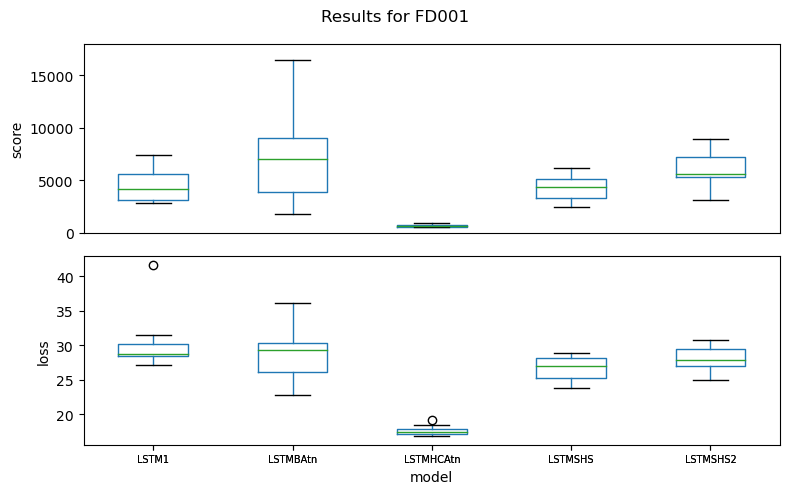

In [132]:
plot_results(df, "FD001")

In [125]:
df.to_csv('results.csv', index=False) 

In [126]:
df.head()

,model_name,loss,score
0,LSTM1,29.988190,3055.541504
1,LSTM1,28.583752,4790.128906
2,LSTM1,27.628591,2815.916138
3,LSTM1,28.312045,5831.285522
4,LSTM1,28.544697,2856.212158


(0.0, 10000.0)

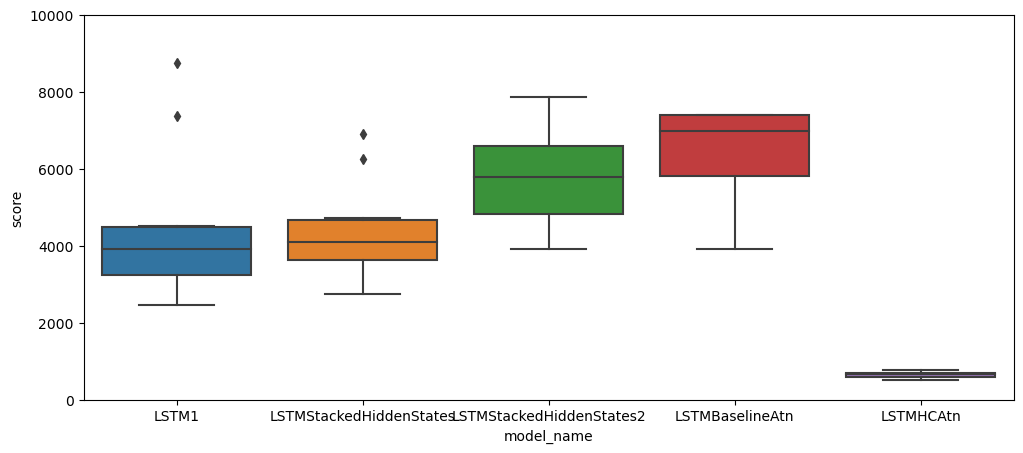

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.boxplot(data=df, x="model_name", y="score")
plt.ylim(0, 10000)

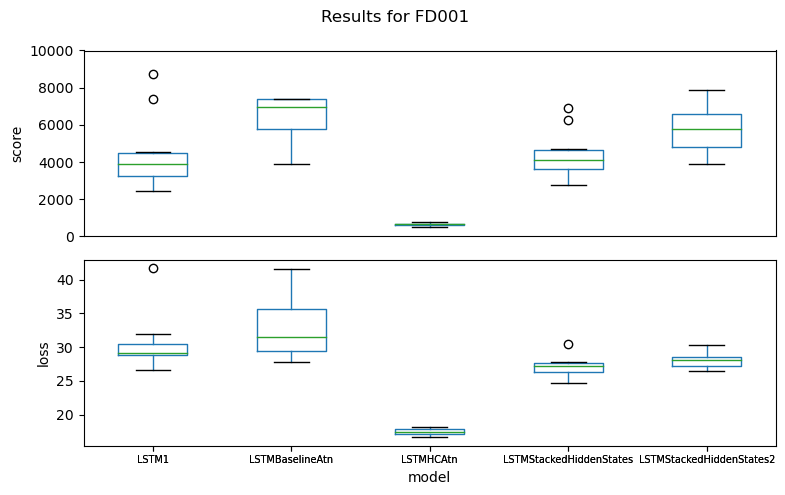

In [110]:
def plot_results(df, data_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)

    df.boxplot(by ="model_name", column ='score', grid = False, ax=axes[0])
    #plt.xticks(rotation=15)
    axes[0].set_ylim(0, 10000)
    #axes[0].xaxis.set_tick_params(labelsize=7)
    axes[0].xaxis.set_visible(False)
    axes[0].set_title("")
    axes[0].set_ylabel('score', fontsize='medium')
    #plt.xticks(fontsize=7, rotation=0)

    df.boxplot(by ="model_name", column ='loss', grid = False,  ax=axes[1])
    axes[1].xaxis.set_visible(True)
    axes[1].set_title("")
    axes[1].xaxis.set_tick_params(labelsize=7)
    axes[1].set_ylabel('loss', fontsize='medium')
    plt.suptitle(f'Results for {data_name}')
    plt.xlabel('model')
    plt.tight_layout();

plot_results(df, "FD001")

In [27]:
w = [1,2,3,4]
w[-1:]
w

[4]

In [46]:
model = LSTM1(input_size=17, seq_length=1, hidden_size=96, num_layers=4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0)
history = trainer.train(epochs)

Device: cuda
Epoch: 1 train loss: 36.994 val loss: 30.615 score: 12186.923
Epoch: 2 train loss: 27.372 val loss: 28.522 score: 8214.798
Epoch: 3 train loss: 26.452 val loss: 31.503 score: 12044.242
Epoch: 4 train loss: 25.924 val loss: 32.308 score: 13199.387
Epoch: 5 train loss: 25.736 val loss: 30.993 score: 10266.152
Epoch: 6 train loss: 25.438 val loss: 32.832 score: 13162.540
Epoch: 7 train loss: 25.429 val loss: 30.069 score: 8423.285
Epoch: 8 train loss: 25.341 val loss: 32.769 score: 12484.694
Epoch: 9 train loss: 25.366 val loss: 32.914 score: 13344.917
Epoch: 10 train loss: 25.321 val loss: 33.654 score: 14335.725
Epoch: 11 train loss: 25.191 val loss: 33.812 score: 15577.949
Epoch: 12 train loss: 25.249 val loss: 33.583 score: 14304.948
Epoch: 13 train loss: 25.194 val loss: 31.589 score: 11023.808
Epoch: 14 train loss: 25.087 val loss: 33.238 score: 14728.107
Epoch: 15 train loss: 25.259 val loss: 35.317 score: 19128.981
Epoch: 16 train loss: 25.216 val loss: 31.834 score: 

In [31]:
model = LSTMStackedHiddenStates(input_size=17, time_steps=30, hidden_size=96, num_layers=4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 60

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0)
history = trainer.train(epochs)

Device: cuda
Epoch: 1 train loss: 37.658 val loss: 33.937 score: 20437.864
Epoch: 2 train loss: 27.302 val loss: 32.196 score: 17786.137
Epoch: 3 train loss: 24.310 val loss: 32.647 score: 19388.890
Epoch: 4 train loss: 23.229 val loss: 31.414 score: 12352.909
Epoch: 5 train loss: 22.567 val loss: 32.714 score: 14543.589
Epoch: 6 train loss: 21.807 val loss: 29.101 score: 7894.909
Epoch: 7 train loss: 20.963 val loss: 33.775 score: 14894.885
Epoch: 8 train loss: 20.509 val loss: 30.342 score: 9874.956
Epoch: 9 train loss: 19.609 val loss: 32.539 score: 10718.567
Epoch: 10 train loss: 19.139 val loss: 32.140 score: 10829.394
Epoch: 11 train loss: 18.524 val loss: 33.307 score: 13092.397
Epoch: 12 train loss: 18.204 val loss: 32.502 score: 10608.090
Epoch: 13 train loss: 17.267 val loss: 31.955 score: 9720.194
Epoch: 14 train loss: 17.201 val loss: 30.874 score: 7813.583
Epoch: 15 train loss: 16.456 val loss: 31.037 score: 10163.430
Epoch: 16 train loss: 16.307 val loss: 32.661 score: 10

In [29]:
model = LSTMStackedHiddenStates2(input_size=17, time_steps=30, hidden_size=96, num_layers=4)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 60

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0)
history = trainer.train(epochs)

Device: cuda
Epoch: 1 train loss: 91.787 val loss: 77.238 score: 4067666.176
Epoch: 2 train loss: 89.442 val loss: 75.061 score: 3136825.551
Epoch: 3 train loss: 87.286 val loss: 72.944 score: 2428801.932
Epoch: 4 train loss: 85.178 val loss: 70.993 score: 1887480.373
Epoch: 5 train loss: 83.075 val loss: 69.296 score: 1469734.026
Epoch: 6 train loss: 48.748 val loss: 37.104 score: 30467.937
Epoch: 7 train loss: 36.722 val loss: 36.970 score: 25122.133
Epoch: 8 train loss: 34.453 val loss: 34.543 score: 20362.019
Epoch: 9 train loss: 32.883 val loss: 35.140 score: 20869.518
Epoch: 10 train loss: 31.954 val loss: 33.066 score: 15641.128
Epoch: 11 train loss: 31.370 val loss: 33.495 score: 16595.260
Epoch: 12 train loss: 30.758 val loss: 33.671 score: 15227.735
Epoch: 13 train loss: 30.766 val loss: 33.208 score: 16680.792
Epoch: 14 train loss: 30.081 val loss: 34.630 score: 16340.863
Epoch: 15 train loss: 30.228 val loss: 33.699 score: 15951.567
Epoch: 16 train loss: 29.068 val loss: 33

In [26]:
model = LSTMBaseline(n_features=17, n_hidden=32, n_layers=4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 60

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0)
history = trainer.train(epochs)

Device: cuda
output shape: [100, 30, 32] hidden shape: [4, 100, 32]
Epoch: 1 train loss: 72.064 val loss: 50.359 score: 187879.227
Epoch: 2 train loss: 51.866 val loss: 41.668 score: 78857.988
Epoch: 3 train loss: 37.421 val loss: 39.925 score: 48641.953
Epoch: 4 train loss: 30.035 val loss: 42.444 score: 91043.059
Epoch: 5 train loss: 27.446 val loss: 43.399 score: 98215.130
Epoch: 6 train loss: 26.735 val loss: 44.140 score: 75467.475
Epoch: 7 train loss: 26.246 val loss: 45.169 score: 79697.635
Epoch: 8 train loss: 25.830 val loss: 43.533 score: 59022.138
Epoch: 9 train loss: 25.720 val loss: 42.915 score: 48805.940
Epoch: 10 train loss: 25.286 val loss: 45.185 score: 59679.663
Epoch: 11 train loss: 25.171 val loss: 42.806 score: 48484.895
Epoch: 12 train loss: 24.387 val loss: 45.775 score: 73346.375
Epoch: 13 train loss: 23.988 val loss: 48.468 score: 101880.016
Epoch: 14 train loss: 24.286 val loss: 48.089 score: 81174.062
Epoch: 15 train loss: 23.754 val loss: 45.530 score: 5521

In [53]:
model = LSTMBaselineAtn(n_features=17, n_hidden=96, time_steps=30)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 60

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0)
history = trainer.train(epochs)

Device: cuda
output shape: 100 30 96 hidden shape: 2 100 96

Epoch: 1 train loss: 61.900 val loss: 45.053 score: 45419.562
Epoch: 2 train loss: 52.418 val loss: 39.077 score: 20406.477
Epoch: 3 train loss: 40.591 val loss: 36.914 score: 39984.907
Epoch: 4 train loss: 31.544 val loss: 35.144 score: 35339.014
Epoch: 5 train loss: 27.596 val loss: 33.484 score: 23988.798
Epoch: 6 train loss: 24.993 val loss: 31.644 score: 17231.094
Epoch: 7 train loss: 23.520 val loss: 32.383 score: 16953.878
Epoch: 8 train loss: 22.482 val loss: 31.475 score: 14895.263
Epoch: 9 train loss: 21.877 val loss: 31.022 score: 13837.921
Epoch: 10 train loss: 21.625 val loss: 30.087 score: 10711.819
Epoch: 11 train loss: 20.763 val loss: 30.511 score: 11083.618
Epoch: 12 train loss: 20.628 val loss: 29.275 score: 9364.439
Epoch: 13 train loss: 20.417 val loss: 29.266 score: 9123.147
Epoch: 14 train loss: 19.763 val loss: 29.094 score: 8455.182
Epoch: 15 train loss: 19.587 val loss: 29.114 score: 8180.497
Epoch: 

In [47]:
MAX_RUL=150

trainset = CMAPSSSlidingWin(mode='train',
                               data_path='./CMAPSSData/train_FD001.txt', max_rul=MAX_RUL, handcrafted=True)
train_loader = DataLoader(dataset=trainset, batch_size=100, shuffle=True, num_workers=2)

testset = CMAPSSSlidingWin(mode='test',
                              data_path='./CMAPSSData/test_FD001.txt',
                              rul_path='./CMAPSSData/RUL_FD001.txt',  max_rul=MAX_RUL, handcrafted=True)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=False, num_workers=2)

print('dataset load successfully!')
print(next(iter(trainset))[0].shape, next(iter(trainset))[1].shape)

dataset load successfully!
torch.Size([30, 17]) torch.Size([34])


In [48]:
trainset.y.shape

(17731,)

In [49]:
testset.x.shape

(100, 30, 17)

In [50]:
testset.hc.shape

(100, 34)

In [51]:
model = LSTMHCAtn()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

trainer = TrainUtil(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0,
                    handcrafted=True)
history = trainer.train(epochs)

Device: cuda
Epoch: 1 train loss: 124.394 val loss: 58.608 score: 389865.750
Epoch: 2 train loss: 51.384 val loss: 31.852 score: 2190.425
Epoch: 3 train loss: 39.413 val loss: 24.693 score: 994.842
Epoch: 4 train loss: 35.094 val loss: 22.373 score: 792.304
Epoch: 5 train loss: 33.798 val loss: 22.723 score: 787.488
Epoch: 6 train loss: 32.420 val loss: 22.046 score: 737.875
Epoch: 7 train loss: 31.509 val loss: 21.896 score: 709.553
Epoch: 8 train loss: 30.397 val loss: 20.895 score: 651.857
Epoch: 9 train loss: 29.817 val loss: 20.732 score: 622.582
Epoch: 10 train loss: 28.607 val loss: 19.744 score: 585.714
Epoch: 11 train loss: 28.027 val loss: 19.680 score: 564.755
Epoch: 12 train loss: 27.526 val loss: 19.178 score: 552.295
Epoch: 13 train loss: 26.853 val loss: 18.968 score: 542.401
Epoch: 14 train loss: 26.719 val loss: 18.854 score: 550.246
Epoch: 15 train loss: 26.407 val loss: 18.651 score: 545.009
Epoch: 16 train loss: 26.248 val loss: 18.719 score: 551.912
Epoch: 17 train

In [77]:
MAX_RUL = 130
trainset = CMAPSSDatasetHC(mode='train',
                               data_path='./CMAPSSData/train_FD001.txt', max_rul=MAX_RUL)
train_loader = DataLoader(dataset=trainset, batch_size=100, shuffle=True, num_workers=2)

testset = CMAPSSDatasetHC(mode='test',
                              data_path='./CMAPSSData/test_FD001.txt',
                              rul_path='./CMAPSSData/RUL_FD001.txt',  max_rul=MAX_RUL)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=False, num_workers=2)

print('dataset load successfully!')
print(next(iter(trainset))[0].shape, next(iter(trainset))[1].shape)

dataset load successfully!
torch.Size([30, 17]) torch.Size([34])


In [72]:
trainset.x.shape

(17731, 30, 17)

In [73]:
testset.x.shape

(100, 30, 17)

In [129]:
model = LSTMBaseline(n_features=17, n_hidden=32)
optimizer = optim.Adam(model.parameters(), lr=3e-6)
epochs = 60

trainer = TrainUtilHC(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0)
history = trainer.train(epochs)

Device: cuda
output shape: [100, 30, 32] hidden shape: [2, 100, 32]
Epoch: 1 train loss: 77.205 val loss: 69.426 score: 1070242.781
Epoch: 2 train loss: 76.381 val loss: 68.564 score: 962208.812
Epoch: 3 train loss: 75.465 val loss: 67.602 score: 853579.750
Epoch: 4 train loss: 74.394 val loss: 66.494 score: 742736.125
Epoch: 5 train loss: 73.321 val loss: 65.408 score: 647193.250
Epoch: 6 train loss: 72.391 val loss: 64.273 score: 559238.828
Epoch: 7 train loss: 71.427 val loss: 63.262 score: 490472.938
Epoch: 8 train loss: 70.201 val loss: 62.019 score: 416701.797
Epoch: 9 train loss: 68.404 val loss: 60.327 score: 332457.266
Epoch: 10 train loss: 66.186 val loss: 58.243 score: 249666.172
Epoch: 11 train loss: 63.788 val loss: 55.859 score: 177549.102
Epoch: 12 train loss: 61.144 val loss: 53.258 score: 119831.699
Epoch: 13 train loss: 58.355 val loss: 50.574 score: 77342.082
Epoch: 14 train loss: 55.381 val loss: 47.939 score: 47946.516
Epoch: 15 train loss: 53.090 val loss: 45.664 

In [65]:
model = LSTMBaselineAtn(n_features=17, n_hidden=50, time_steps=30)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 20

trainer = TrainUtilHC(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0)
history = trainer.train(epochs)

Device: cuda
output shape: 100 30 50 hidden shape: 2 100 50

Epoch: 1 train loss: 74.438 val loss: 62.626 score: 1887591.844
Epoch: 2 train loss: 70.535 val loss: 54.540 score: 402725.047
Epoch: 3 train loss: 56.740 val loss: 49.532 score: 50010.076
Epoch: 4 train loss: 51.770 val loss: 51.122 score: 44304.367
Epoch: 5 train loss: 51.382 val loss: 51.263 score: 45131.449
Epoch: 6 train loss: 51.226 val loss: 51.290 score: 45298.317
Epoch: 7 train loss: 51.180 val loss: 51.321 score: 45489.186
Epoch: 8 train loss: 51.136 val loss: 51.347 score: 45652.155
Epoch: 9 train loss: 51.078 val loss: 51.352 score: 45687.467
Epoch: 10 train loss: 51.014 val loss: 51.321 score: 45491.335
Epoch: 11 train loss: 51.008 val loss: 51.228 score: 44919.338
Epoch: 12 train loss: 50.913 val loss: 51.237 score: 44971.194
Epoch: 13 train loss: 50.967 val loss: 51.192 score: 44706.427
Epoch: 14 train loss: 50.904 val loss: 51.379 score: 45858.915
Epoch: 15 train loss: 50.912 val loss: 51.204 score: 44773.965


In [130]:
model = LSTMHCAtn()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 40

trainer = TrainUtilHC(model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    max_rul=MAX_RUL,
                    verbosity=0)
history = trainer.train(epochs)

Device: cuda
Epoch: 1 train loss: 102.100 val loss: 91.346 score: 30705721.000
Epoch: 2 train loss: 99.609 val loss: 88.976 score: 19733672.000
Epoch: 3 train loss: 96.735 val loss: 85.774 score: 11791595.250
Epoch: 4 train loss: 93.061 val loss: 81.243 score: 6189282.750
Epoch: 5 train loss: 87.411 val loss: 74.190 score: 2485348.750
Epoch: 6 train loss: 77.470 val loss: 61.318 score: 497107.562
Epoch: 7 train loss: 65.036 val loss: 49.634 score: 102145.559
Epoch: 8 train loss: 54.394 val loss: 40.299 score: 25159.545
Epoch: 9 train loss: 46.150 val loss: 33.690 score: 7725.400
Epoch: 10 train loss: 40.263 val loss: 29.873 score: 3260.595
Epoch: 11 train loss: 36.711 val loss: 27.956 score: 1943.964
Epoch: 12 train loss: 34.821 val loss: 26.915 score: 1481.059
Epoch: 13 train loss: 33.228 val loss: 26.081 score: 1260.547
Epoch: 14 train loss: 32.477 val loss: 25.303 score: 1116.995
Epoch: 15 train loss: 31.501 val loss: 24.543 score: 1005.788
Epoch: 16 train loss: 30.801 val loss: 23.

In [4]:
class TimeSeriesDataset(Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - self.seq_len

    def __getitem__(self, index):
        return self.X[index:index+self.seq_len], self.y[index+self.seq_len]

In [78]:
def train_model(
        model,
        train_df,
        test_df,
        label_name,
        sequence_length,
        batch_size,
        n_epochs,
        n_epochs_stop,
        lr
):
    """Train LSTM model."""
    print("Starting with model training...")

    # create dataloaders
    train_dataset = TimeSeriesDataset(np.array(train_df), np.array(train_df[label_name]), seq_len=sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = TimeSeriesDataset(np.array(test_df), np.array(test_df[label_name]), seq_len=sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

    # set up training
    #n_features = train_df.shape[1]
    #model = TSModel(n_features)
    criterion = torch.nn.MSELoss()  # L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_hist = []
    test_hist = []

    # start training
    best_loss = np.inf
    epochs_no_improve = 0
    for epoch in range(1, n_epochs+1):
        running_loss = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader, 1):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            data = torch.Tensor(np.array(data))
            
            if (epoch == 1) and (batch_idx == 1):
                print("input shape:", *data.shape)
            
            output = model(data)
            
            if (epoch == 1) and (batch_idx == 1):
                print("model output:", *output.shape)
                print()
            
            loss = criterion(output.flatten(), target.type_as(output))
            # if type(criterion) == torch.nn.modules.loss.MSELoss:
            #     loss = torch.sqrt(loss)  # RMSE
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        running_loss /= len(train_loader)
        train_hist.append(running_loss)

        # test loss
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = torch.Tensor(np.array(data))
                output = model(data)
                loss = criterion(output.flatten(), target.type_as(output))
                test_loss += loss.item()
            test_loss /= len(test_loader)
            test_hist.append(test_loss)

            # early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), Path(model_dir, 'model.pt'))
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print("Early stopping.")
                break

        print(f'Epoch {epoch} train loss: {round(running_loss,4)} test loss: {round(test_loss,4)}')

        hist = pd.DataFrame()
        hist['training_loss'] = train_hist
        hist['test_loss'] = test_hist

    print("Completed.")

    return hist


In [52]:
df_train = pd.read_csv("../data/train.csv")
df_train

,Close,Volume,High_Low_Pct,Open_Close_Pct,Day_Of_Week,Month_Of_Year,Quarter_Of_Year
0,0.000000,0.008925,0.081764,0.193811,0.833333,1.0,1.0
1,0.006946,0.020057,0.047454,0.192291,1.000000,1.0,1.0
2,0.009084,0.011096,0.000000,0.189650,0.000000,1.0,1.0
3,0.012580,0.023945,0.019690,0.191727,0.166667,1.0,1.0
4,0.051411,0.077130,0.239106,0.186352,0.333333,1.0,1.0
...,...,...,...,...,...,...,...
360,0.654109,0.044822,0.048717,0.171630,0.166667,1.0,1.0
361,0.650104,0.029176,0.084043,0.159411,0.333333,1.0,1.0
362,0.592014,0.032559,0.141697,0.171933,0.500000,1.0,1.0
363,0.583220,0.036661,0.119429,0.201692,0.666667,1.0,1.0


In [53]:
df_test = pd.read_csv("../data/test.csv")
df_test

,Close,Volume,High_Low_Pct,Open_Close_Pct,Day_Of_Week,Month_Of_Year,Quarter_Of_Year
0,0.641769,0.009487,0.063496,0.198277,1.000000,1.0,1.0
1,0.572847,0.040276,0.194433,0.172954,0.000000,1.0,1.0
2,0.570286,0.047717,0.068952,1.233623,0.166667,1.0,1.0
3,0.617127,0.053446,0.110560,0.191364,0.333333,1.0,1.0
4,0.591876,0.025529,0.060670,0.182496,0.500000,1.0,1.0
...,...,...,...,...,...,...,...
360,-0.040103,0.002671,0.014960,0.187984,0.333333,1.0,1.0
361,-0.032200,0.005144,0.032581,0.187136,0.500000,1.0,1.0
362,-0.034257,0.004637,-0.012056,0.190973,0.666667,1.0,1.0
363,-0.034348,-0.018307,-0.024171,0.190842,0.833333,1.0,1.0


In [54]:
df = pd.read_csv("../data/BTC-USD.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-12,18051.320313,18919.550781,18046.041016,18803.656250,18803.656250,21752580802
1,2020-12-13,18806.765625,19381.535156,18734.332031,19142.382813,19142.382813,25450468637
2,2020-12-14,19144.492188,19305.099609,19012.708984,19246.644531,19246.644531,22473997681
3,2020-12-15,19246.919922,19525.007813,19079.841797,19417.076172,19417.076172,26741982541
4,2020-12-16,19418.818359,21458.908203,19298.316406,21310.597656,21310.597656,44409011479
...,...,...,...,...,...,...,...
726,2022-12-08,16847.349609,17267.916016,16788.783203,17233.474609,17233.474609,20496603770
727,2022-12-09,17232.148438,17280.546875,17100.835938,17133.152344,17133.152344,20328426366
728,2022-12-10,17134.220703,17216.826172,17120.683594,17128.724609,17128.724609,12706781969
729,2022-12-11,17129.710938,17245.634766,17091.820313,17104.193359,17104.193359,14122486832


In [55]:
2*365

730

In [111]:
train_model(
        TSModel(df_train.shape[1]),
        df_train,
        df_test,
        "Close",
        sequence_length=30,
        batch_size=10,
        n_epochs=40,
        n_epochs_stop=20,
        lr=0.001
)

Starting with model training...
input shape: 10 30 7
output shape: 10 30 64 hidden shape: 2 10 64
model output: 10 1

Epoch 1 train loss: 0.1495 test loss: 0.2826
Epoch 2 train loss: 0.0552 test loss: 0.1772
Epoch 3 train loss: 0.0611 test loss: 0.1177
Epoch 4 train loss: 0.0655 test loss: 0.1097
Epoch 5 train loss: 0.0517 test loss: 0.1274
Epoch 6 train loss: 0.046 test loss: 0.1184
Epoch 7 train loss: 0.0396 test loss: 0.1027
Epoch 8 train loss: 0.0378 test loss: 0.0871
Epoch 9 train loss: 0.0323 test loss: 0.0674
Epoch 10 train loss: 0.0285 test loss: 0.04
Epoch 11 train loss: 0.0244 test loss: 0.0245
Epoch 12 train loss: 0.011 test loss: 0.0196
Epoch 13 train loss: 0.0099 test loss: 0.0512
Epoch 14 train loss: 0.0113 test loss: 0.0423
Epoch 15 train loss: 0.006 test loss: 0.0314
Epoch 16 train loss: 0.0057 test loss: 0.0288
Epoch 17 train loss: 0.0055 test loss: 0.026
Epoch 18 train loss: 0.0057 test loss: 0.022
Epoch 19 train loss: 0.0053 test loss: 0.029
Epoch 20 train loss: 0.00

,training_loss,test_loss
0,0.149510,0.282596
1,0.055157,0.177239
2,0.061057,0.117689
3,0.065541,0.109684
4,0.051653,0.127381
5,0.045953,0.118389
6,0.039573,0.102711
7,0.037757,0.087150
8,0.032257,0.067441
9,0.028499,0.040018


In [133]:
class AttentionBlock(nn.Module):
    def __init__(self, time_steps=30):
        super(AttentionBlock, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(time_steps, time_steps),
            #nn.Softmax(dim=2),
            nn.Sigmoid()
        )

    # inputs: batch size * window size(time step) * lstm output dims
    def forward(self, inputs):
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x_probs = x.permute(0, 2, 1)
        #print("probs")
        #print(x_probs)
        #print()
        # print(torch.sum(x_probs.item()))
        output = x_probs * inputs
        return output

    
class TSModelAttention(nn.Module):
    def __init__(self, n_features, time_steps, n_hidden=64, n_layers=2):
        super(TSModelAttention, self).__init__()

        self.n_hidden = n_hidden
        self.time_steps = time_steps
        self.n_features = n_features
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers
        )
        self.attention = AttentionBlock(time_steps)
        self.linear = nn.Linear(self.time_steps*self.n_hidden, 1)
        self.printed = False
        
    def forward(self, x):
        lstm_output, (hidden, _) = self.lstm(x)
        if not self.printed:
            print("output shape:", *lstm_output.shape, "hidden shape:", *hidden.shape)
            self.printed=True
            print()
        x = self.attention(lstm_output)
        #print(x)
        #print()
        #print(x.shape)
        x = x.reshape(-1, self.time_steps*self.n_hidden)
        #print("x shape", x.shape)
        lstm_out = hidden[-1]  # output last hidden state output
        y_pred = self.linear(x)
        
        return y_pred

In [135]:
train_model(
        TSModelAttention(df_train.shape[1],  30, n_hidden=64, n_layers=1),
        df_train,
        df_test,
        "Close",
        sequence_length=30,
        batch_size=10,
        n_epochs=30,
        n_epochs_stop=20,
        lr=0.001
)

Starting with model training...
input shape: 10 30 7
output shape: 10 30 64 hidden shape: 1 10 64

model output: 10 1

Epoch 1 train loss: 0.137 test loss: 0.1445
Epoch 2 train loss: 0.0605 test loss: 0.1355
Epoch 3 train loss: 0.0612 test loss: 0.1225
Epoch 4 train loss: 0.0504 test loss: 0.1176
Epoch 5 train loss: 0.0432 test loss: 0.1059
Epoch 6 train loss: 0.0393 test loss: 0.0937
Epoch 7 train loss: 0.036 test loss: 0.0824
Epoch 8 train loss: 0.032 test loss: 0.0712
Epoch 9 train loss: 0.0274 test loss: 0.0597
Epoch 10 train loss: 0.0226 test loss: 0.0484
Epoch 11 train loss: 0.0178 test loss: 0.0376
Epoch 12 train loss: 0.0134 test loss: 0.0284
Epoch 13 train loss: 0.0101 test loss: 0.0243
Epoch 14 train loss: 0.0082 test loss: 0.0267
Epoch 15 train loss: 0.0076 test loss: 0.0312
Epoch 16 train loss: 0.0073 test loss: 0.0344
Epoch 17 train loss: 0.0071 test loss: 0.0353
Epoch 18 train loss: 0.0073 test loss: 0.035
Epoch 19 train loss: 0.0081 test loss: 0.0338
Epoch 20 train loss:

,training_loss,test_loss
0,0.137022,0.144499
1,0.060537,0.135549
2,0.061200,0.122494
3,0.050381,0.117582
4,0.043236,0.105892
5,0.039307,0.093682
6,0.035971,0.082431
7,0.032012,0.071198
8,0.027418,0.059735
9,0.022584,0.048439


In [14]:
class A:
    def __init__(self):
        print('Initializing: class A')

    def sub_method(self, b):
        print('sub_method from class A:', b)


class B(A):
    def __init__(self):
        print('Initializing: class B')
        super().__init__()

    def sub_method(self, b):
        print('sub_method from class B:', b)
        super().sub_method(b + 1)

class X(B):
    def __init__(self):
        print('Initializing: class X')
        super().__init__()

    def sub_method(self, b):
        print('sub_method from class X:', b)
        super().sub_method(b + 1)


class Y(X):
    def __init__(self):
        print('Initializing: class Y')
        # super() с параметрами
        super(Y, self).__init__()

    def sub_method(self, b):
        print('sub_method from class Y:', b)
        super().sub_method(b + 1)


x = X()
x.sub_method(1)
print('Обратите внимание как происходит инициализация')
print('классов при указании аргументов в функции super()')
y = Y()
y.sub_method(5)

Initializing: class X
Initializing: class B
Initializing: class A
sub_method from class X: 1
sub_method from class B: 2
sub_method from class A: 3
Обратите внимание как происходит инициализация
классов при указании аргументов в функции super()
Initializing: class Y
Initializing: class X
Initializing: class B
Initializing: class A
sub_method from class Y: 5
sub_method from class X: 6
sub_method from class B: 7
sub_method from class A: 8


In [15]:
class Y(X):
    def __init__(self):
        print('Initializing: class Y')
        # super() с параметрами
        super(X, self).__init__()

    def sub_method(self, b):
        print('sub_method from class Y:', b)
        super().sub_method(b + 1)


x = X()
x.sub_method(1)
print('Обратите внимание как происходит инициализация')
print('классов при указании аргументов в функции super()')
y = Y()
y.sub_method(5)

Initializing: class X
Initializing: class B
Initializing: class A
sub_method from class X: 1
sub_method from class B: 2
sub_method from class A: 3
Обратите внимание как происходит инициализация
классов при указании аргументов в функции super()
Initializing: class Y
Initializing: class B
Initializing: class A
sub_method from class Y: 5
sub_method from class X: 6
sub_method from class B: 7
sub_method from class A: 8


In [40]:
x = torch.randn(2, 2, 3)
print(x)
print(x.shape)

print()
print(torch.transpose(x, 1, 2))
print()
print(torch.transpose(x,-1, -2))
print()
print(torch.transpose(x,-2, -1))
print()
print(torch.transpose(x,0, 1))

tensor([[[ 0.2600,  0.4525, -1.4906],
         [ 0.0912,  2.4932,  0.2790]],

        [[ 0.0041,  0.0553,  0.6910],
         [-0.0967,  0.6487,  0.2092]]])
torch.Size([2, 2, 3])

tensor([[[ 0.2600,  0.0912],
         [ 0.4525,  2.4932],
         [-1.4906,  0.2790]],

        [[ 0.0041, -0.0967],
         [ 0.0553,  0.6487],
         [ 0.6910,  0.2092]]])

tensor([[[ 0.2600,  0.0912],
         [ 0.4525,  2.4932],
         [-1.4906,  0.2790]],

        [[ 0.0041, -0.0967],
         [ 0.0553,  0.6487],
         [ 0.6910,  0.2092]]])

tensor([[[ 0.2600,  0.0912],
         [ 0.4525,  2.4932],
         [-1.4906,  0.2790]],

        [[ 0.0041, -0.0967],
         [ 0.0553,  0.6487],
         [ 0.6910,  0.2092]]])

tensor([[[ 0.2600,  0.4525, -1.4906],
         [ 0.0041,  0.0553,  0.6910]],

        [[ 0.0912,  2.4932,  0.2790],
         [-0.0967,  0.6487,  0.2092]]])
